# Neo-Whisper Training from Scratch

# lib install

In [ ]:
%%capture
! pip install jiwer evaluate
! pip install datasets[audio]
! pip install git+https://github.com/openai/whisper.git

In [ ]:
! pip install neo-whisper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Import

In [ ]:
from datasets import load_dataset

ds = load_dataset("Kimang18/khmer-mpwt-speech-clean").with_format("numpy")
ds

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/441 [00:00<?, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/325M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/338M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2058 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 2058
    })
})

In [ ]:
SEED = 3407

print(ds['train'][0])
ds = ds['train'].train_test_split(test_size=0.05, seed=SEED)
ds

{'audio': {'array': array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
       -3.6848349e-05, -1.0379205e-05, -1.9985937e-05], dtype=float32), 'path': 'q-CatID02.mp3', 'sampling_rate': array(16000)}, 'transcription': np.str_('ផ្លាក សញ្ញា នេះ មាន ន័យ ដូចម្ដេច')}


DatasetDict({
    train: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 1955
    })
    test: Dataset({
        features: ['audio', 'transcription'],
        num_rows: 103
    })
})

In [ ]:
from neo_whisper import get_tokenizer


tokenizer_name = "cl100k_base"
wtokenizer = get_tokenizer(True, language='km', task='transcribe', encoder_name=tokenizer_name)
print(wtokenizer.eot)
#print(wtokenizer.bos_token_id)

100256


In [ ]:
from neo_whisper import pad_or_trim, log_mel_spectrogram
import torch


class KmSpeechDataset(torch.utils.data.Dataset):
    def __init__(self, ds, tokenizer) -> None:
        super().__init__()

        self.dataset = ds
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, id):

        # audio
        audio = self.dataset[id]['audio']['array']
        audio = pad_or_trim(audio.flatten())
        mel = log_mel_spectrogram(np.array(audio, dtype=np.float32))

        text = self.dataset[id]['transcription'].strip()
        text = [*self.tokenizer.sot_sequence_including_notimestamps] + self.tokenizer.encode(text)
        labels = text[1:] + [self.tokenizer.eot]

        return {
            "input_ids": mel,
            "labels": labels,
            "dec_input_ids": text
        }

In [ ]:
import numpy as np
n_text_ctx = 448


class WhisperDataCollatorWithPadding:
    def __call__(self, features):
        input_ids, labels, dec_input_ids = [], [], []
        for f in features:
            input_ids.append(f["input_ids"])
            labels.append(f["labels"])
            dec_input_ids.append(f["dec_input_ids"])

        input_ids = torch.concat([input_id[None, :] for input_id in input_ids])

        label_lengths = [len(lab) for lab in labels]
        dec_input_ids_length = [len(e) for e in dec_input_ids]
        max_label_len = max(label_lengths+dec_input_ids_length)

        # truncate
        max_label_len = min(n_text_ctx, max_label_len)

        labels = [np.pad(lab, (0, max_label_len - lab_len), 'constant', constant_values=-100) for lab, lab_len in zip(labels, label_lengths)]
        dec_input_ids = [np.pad(e, (0, max_label_len - e_len), 'constant', constant_values=wtokenizer.eot) for e, e_len in zip(dec_input_ids, dec_input_ids_length)] # 50257 is eot token id

        batch = {
            "labels": labels,
            "dec_input_ids": dec_input_ids
        }

        batch = {k: torch.tensor(np.array(v)) for k, v in batch.items()}
        batch["input_ids"] = input_ids

        return batch

# Confirm Dataloading

In [ ]:
dataset = KmSpeechDataset(ds['train'], wtokenizer)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=WhisperDataCollatorWithPadding())

In [ ]:
for b in train_loader:
    print(b["labels"].shape)
    print(b["input_ids"].shape)
    print(b["dec_input_ids"].shape)

    for token, dec in zip(b["labels"], b["dec_input_ids"]):
        token[token == -100] = wtokenizer.eot
        text = wtokenizer.decode(token, skip_special_tokens=False)
        print(text)

        text = wtokenizer.decode(dec, skip_special_tokens=False)
        print(text)


    break

torch.Size([2, 116])
torch.Size([2, 80, 3000])
torch.Size([2, 116])
<|km|><|transcribe|><|notimestamps|>ហាម ចត នៅ ផ្លូវ បំបែក រាង អ៊ីការិច នៅ ខាង មុខ<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
<|startoftranscript|><|km|><|transcribe|><|notimestamps|>ហាម ចត នៅ ផ្លូវ បំបែក រាង អ៊ីការិច នៅ ខាង មុខ<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endof

In [ ]:
from neo_whisper import DecodingOptions

# woptions = DecodingOptions(language="km", without_timestamps=True, tokenizer_name=tokenizer_name)
wtokenizer = get_tokenizer(True, language="km", task='transcribe', encoder_name=tokenizer_name)

In [ ]:
from neo_whisper import NeoWhisper, NeoModelDimensions
dims = NeoModelDimensions(
    n_vocab=wtokenizer.encoding.n_vocab, # use the tokenizer's vocab size
    n_mels=80,
    n_audio_ctx=1500,
    n_audio_state=384,
    n_audio_head=6,
    n_audio_layer=4,
    n_text_ctx=n_text_ctx,
    n_text_state=384,
    n_text_head=6,
    n_text_kv_head=6,
    n_text_layer=4
)

wmodel = NeoWhisper(dims, neo_encoder=False, verbose=True)


 █████   ████                                                    █████████   █████
░░███   ███░                                                    ███░░░░░███ ░░███ 
 ░███  ███    ████████   ██████  ████████  ████████    ███████ ░███    ░███  ░███ 
 ░███████    ░░███░░███ ███░░███░░███░░███░░███░░███  ███░░███ ░███████████  ░███ 
 ░███░░███    ░███ ░░░ ░███ ░███ ░███ ░░░  ░███ ░███ ░███ ░███ ░███░░░░░███  ░███ 
 ░███ ░░███   ░███     ░███ ░███ ░███      ░███ ░███ ░███ ░███ ░███    ░███  ░███ 
 █████ ░░████ █████    ░░██████  █████     ████ █████░░███████ █████   █████ █████
░░░░░   ░░░░ ░░░░░      ░░░░░░  ░░░░░     ░░░░ ░░░░░  ░░░░░███░░░░░   ░░░░░ ░░░░░ 
                                                      ███ ░███                    
                                                     ░░██████                     
                                                      ░░░░░░                      
    


In [ ]:
import whisper

wmodel.encoder.load_state_dict(whisper.load_model("tiny").encoder.state_dict())

100%|██████████████████████████████████████| 72.1M/72.1M [00:00<00:00, 102MiB/s]


<All keys matched successfully>

In [ ]:
with torch.no_grad():
    wmodel.to("cuda")
    dec_input_ids = b["dec_input_ids"].long()
    print(dec_input_ids)
    labels = b["labels"].long()
    print(labels)

    input_ids = b["input_ids"]
    audio_features = wmodel.encoder(input_ids.cuda())
    print(audio_features.shape)
    print(labels.shape, dec_input_ids.shape, audio_features.shape)
    print()
    out = wmodel.decoder(dec_input_ids.cuda(), audio_features)

tensor([[100257, 100322, 100358, 100362,  21549,    254,  98629,    246,    220,
          21549,    227,  21549,    237,    220,  21549,    241,  45358,    227,
            220,  21549,    243,  73673,    249,  21549,    120,  21549,    250,
            220,  21549,    242,  45358,    228,  21549,    242,  45358,    224,
          21549,    222,    220,  21549,    248,  98629,    226,    220,  21549,
             95,  45358,    232,  21549,    116,  21549,    222,  98629,    248,
          21549,    115,  21549,    227,    220,  21549,    241,  45358,    227,
            220,  21549,    223,  98629,    226,    220,  21549,    246,  21549,
            119,  21549,    223, 100256, 100256, 100256, 100256, 100256, 100256,
         100256, 100256, 100256, 100256, 100256, 100256, 100256, 100256, 100256,
         100256, 100256, 100256, 100256, 100256, 100256, 100256, 100256, 100256,
         100256, 100256, 100256, 100256, 100256, 100256, 100256, 100256, 100256,
         100256, 100256, 100

In [ ]:
print(out.shape)
print(out.view(-1, out.size(-1)).shape)
print(b["labels"].view(-1).shape)

torch.Size([2, 116, 101864])
torch.Size([232, 101864])
torch.Size([232])


In [ ]:
tokens = torch.argmax(out, dim=2)
for token in tokens:
    text = wtokenizer.decode(token, skip_special_tokens=True)
    print(text)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# Trainer

In [ ]:
from torch import nn
import torch.nn.functional as F

def estimate_loss(model):
    out = {}
    model.eval()
    eval_steps = 50
    with torch.inference_mode():
        for split, loader in zip(['train', 'val'], [train_loader, eval_loader]):
            losses = torch.zeros(eval_steps)
            k = 0
            for batch in loader:
                input_ids = batch["input_ids"].to(device)
                labels = batch["labels"].long().to(device)
                dec_input_ids = batch["dec_input_ids"].long().to(device)
                with ctx:
                    preds = model(input_ids, dec_input_ids)
                    loss = F.cross_entropy(preds.view(-1, preds.size(-1)), labels.view(-1), ignore_index=-100, reduction='mean')
                losses[k] = loss.item()

                k += 1
                if k >= eval_steps:
                    break
            out[split] = losses.mean()
    model.train()
    return out

In [ ]:
import torch
from contextlib import nullcontext


learning_rate = 1e-3
min_lr = 2e-4
max_steps = 4000
warmup_steps = 200
eval_steps = 400
weight_decay = 0.001
adam_epsilon = 1e-9
batch_size = 4

gradient_accumulation_steps = 8

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if 'cuda' in device else 'cpu'

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
# print(ptdtype)
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

torch.set_default_device(device)
torch.manual_seed(SEED)

dataset = KmSpeechDataset(ds['train'], wtokenizer)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=WhisperDataCollatorWhithPadding())
dataset = KmSpeechDataset(ds['test'], wtokenizer)
eval_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, collate_fn=WhisperDataCollatorWhithPadding())

In [ ]:
# only decoder training
for p in wmodel.encoder.parameters():
    p.requires_grad = False
total_params = sum([p.numel() for p in wmodel.parameters()]) / 1e6
num_params = sum([p.numel() for p in wmodel.parameters() if p.requires_grad]) / 1e6
print(num_params, '/', total_params)

87.685632 / 95.318016


In [ ]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

optimizer = torch.optim.AdamW(wmodel.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=weight_decay, eps=adam_epsilon)

scheduler_warmup = LinearLR(optimizer, total_iters=warmup_steps)
scheduler_decay = CosineAnnealingLR(optimizer, T_max = max_steps - warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, scheduler_decay], milestones=[warmup_steps])

scaler = torch.amp.GradScaler('cuda', enabled=(dtype == 'float16'))

In [ ]:
import torch.nn.functional as F
from tqdm.notebook import tqdm

best_val_loss = float('inf')
best_model_params_path = 'best_model_params.pt'
train_loss_list, valid_loss_list = [], []

wmodel = wmodel.to(device)

it = 0
with tqdm(total=max_steps) as pbar:
    while it < max_steps:
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].long().to(device)
            dec_input_ids = batch["dec_input_ids"].long().to(device)

            with ctx:
                with torch.no_grad():
                    audio_features = wmodel.encoder(input_ids)
                out = wmodel.decoder(dec_input_ids, audio_features)

                loss = F.cross_entropy(out.view(-1, out.size(-1)), labels.view(-1), ignore_index=-100, reduction='mean')
                loss = loss / gradient_accumulation_steps
                scaler.scale(loss).backward()

            if ((it + 1) % gradient_accumulation_steps == 0) or (it + 1 == max_steps):
                torch.nn.utils.clip_grad_norm_(wmodel.parameters(), max_norm=0.5)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
            scheduler.step()

            if (it+1) % eval_steps == 0:
                losses = estimate_loss(wmodel)
                print(f"Iterations {it+1}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
                print(f"The current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
                train_loss_list += [losses['train']]
                valid_loss_list += [losses['val']]

                if losses['val'] < best_val_loss:
                    best_val_loss = losses['val']
                    torch.save(wmodel.state_dict(), best_model_params_path)

            it += 1
            pbar.update(1) # Update the progress bar by 1 unit
            if it >= max_steps:
                break

  0%|          | 0/4000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Iterations 400: train loss 1.8999, val loss 0.9775
The current learning rate: 0.00099
Iterations 800: train loss 1.4349, val loss 0.7339
The current learning rate: 0.00095
Iterations 1200: train loss 1.0049, val loss 0.5336
The current learning rate: 0.00087
Iterations 1600: train loss 0.6422, val loss 0.3837
The current learning rate: 0.00076
Iterations 2000: train loss 0.4538, val loss 0.3019
The current learning rate: 0.00063
Iterations 2400: train loss 0.3591, val loss 0.2641
The current learning rate: 0.00050
Iterations 2800: train loss 0.2542, val loss 0.2359
The current learning rate: 0.00038
Iterations 3200: train loss 0.1665, val loss 0.2221
The current learning rate: 0.00028
Iterations 3600: train loss 0.1201, val loss 0.2234
The current learning rate: 0.00022
Iterations 4000: train loss 0.0747, val loss 0.2229
The current learning rate: 0.00020


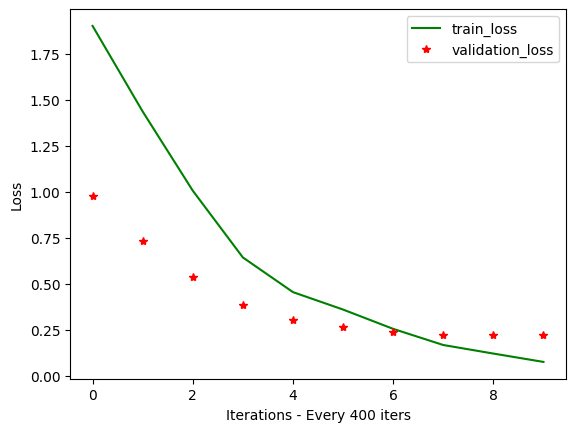

In [ ]:
import matplotlib.pyplot as plt
train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
validation_loss_list_converted = [i.cpu().detach() for i in valid_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(validation_loss_list_converted, 'r*', label='validation_loss')
plt.xlabel(f"Iterations - Every {eval_steps} iters")
plt.ylabel("Loss")
plt.legend()
plt.show()



# load weight and inference

In [ ]:
best_model_params_path = "/content/best_model_params.pt"
wmodel.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))
woptions = DecodingOptions(language="km", without_timestamps=True, tokenizer_name=tokenizer_name)

dataset = KmSpeechDataset(ds['test'], wtokenizer)

refs = []
pred = []
wmodel.eval()
i = 0
with torch.inference_mode():
    for sample in tqdm(dataset):
        mel = sample["input_ids"].to(device)

        out = wmodel.decode(mel, woptions)
        pred.append(out.text)

        label = torch.tensor(sample["labels"]).long().to(device)
        label[label == -100] = wtokenizer.eot
        refs.append(wtokenizer.decode(label, skip_special_tokens=True))

  0%|          | 0/103 [00:00<?, ?it/s]

In [ ]:
import evaluate


cer_metrics = evaluate.load("cer")
cer_metrics.compute(references=refs, predictions=pred)

0.42064932446057673

In [ ]:
wer_metrics = evaluate.load("wer")
wer_metrics.compute(references=refs, predictions=pred)

0.5708418891170431

In [ ]:
for k, v in zip(refs, pred):
    print("-"*10)
    print(k)
    print(v)

----------
ត្រូវ ឈប់ ឬ ចត ខាងស្ដាំ ដៃ តាម ទិស ចរាចរណ៍ របស់ ខ្លួន
ត្រូវ ឈប់ រថយន្ត ខាង ស្ដាំ ធ្វើ ដែល ទិតស បរាចរណ៍ ល្អ
----------
ហាម ចូល ចំពោះ រថយន្ត ប្រភេទ ដឹក ទំនិញ ធុន ធំ មាន សណ្ដោង រ៉ឺម៉ក
ហាម ចូល ចំពោះ រថយន្ត ប្រភេទ ដឹក ទំនិញ ធុន មាន សណ្ដោង
----------
លេខ បី ទៅ មុន បន្ទាប់មក លេខ ពីរ និង លេខ មួយ
លេខ បី ទៅ មុន បន្ទាប់មក លេខ ពីរ និង លេខ មួយ
----------
យ៉ាងតិច ដប់ ម៉ែត្រ
យ៉ាងតិច ដប់ ម៉ែត្រ
----------
នៅ ក្នុង ទីក្រុង ឬ ទីប្រជុំជន រថយន្ត ធុន តូច ត្រូវ បាន កម្រិត ល្បឿន អតិបរមា ប៉ុន្មាន គីឡូម៉ែត្រ ក្នុង មួយ ម៉ោង
នៅក្នុង ទីប្រុងនួយ រថយន្ត តើ ទិតតិន រថយន្ត តើ ទិប ត្រូវ ទិកសិប ប៉ុន្មាន កន្លិប កីរ ម៉ោង ប៉ុន្មាន កម្រើង ម៉ុន្មាន
----------
ភាព លេច ជ្រាប ខ្យល់
ភាព លេច ជ្រាប ជាល
----------
តម្រូវ ឱ្យ យានជំនិះ គ្រប់ ប្រភេទ ឈប់ ឬ ចត នៅ ខាង ឆ្វេង ដៃ
តម្រូវ ឱ្យ យានជំនិះ គ្រប់ ប្រភេទ ចរណ៍ នៅ ខាង ឆ្វេង ដូចក់
----------
ប្រកាន់ ឆ្វេង
ប្រកាន់ ខាង ឆ្វេង
----------
ពាក់ មួក សុវត្ថិភាព ទាំង អ្នកបើកបរ និង អ្នករួមដំណើរ
ពិមូល សម្រាប់ ទិបកស លើបបករ និង អ្នករូម្ម៉ាម៉ុន្មាន
----------
មិន បាន ទេ ព្រោះ វា ធ្វើ ឱ្យ 

In [ ]:
from neo_whisper import transcribe
idx = 18

result = transcribe(wmodel, ds['test'][idx]['audio']['array'], verbose=True, word_timestamps=True, tokenizer_name=tokenizer_name)
print(result['text'], '\n', ds['test'][idx]['transcription'])

Detecting language using up to the first 30 seconds. Use `--language` to specify the language
Detected language: Khmer
[00:00.000 --> 00:01.620] ពណ៍ របស់ របស់ ម៉ាស៊ីន
[00:01.600 --> 00:01.620] ដាំ
ពណ៍ របស់ របស់ ម៉ាស៊ីនដាំ 
 ពណ៌ របស់ ម៉ាស៊ីន
